In [1]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
import albumentations as A
from tqdm import tqdm

# torch imports
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# image encoders
import timm

# text encoders
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from transformers import GPT2Tokenizer, GPT2Model
from peft import LoraConfig, get_peft_model, TaskType

/Volumes/DrowZz/personal_work/vision/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_path = "./dataset30k/Flicker30k_Dataset/"
captions_path = "./dataset30k/"

In [3]:
# captions data
data = pd.read_csv(f"./{captions_path}/Flickr30k.token.txt", sep=",")

# data[['image', 'caption_number']] = data['image'].str.split('#', expand=True)
data["id"] = data.groupby("image").ngroup()
data["caption_number"] = data.groupby("image").cumcount()

data.head(2)

,image,caption,id,caption_number
0,1000092795.jpg,Two young guys with shaggy hair look at their...,0,0
1,1000092795.jpg,"Two young , White males are outside near many...",0,1


In [4]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158914 entries, 0 to 158914
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image           158914 non-null  object
 1   caption         158914 non-null  object
 2   id              158914 non-null  int64 
 3   caption_number  158914 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.1+ MB


In [5]:
# sanity check
for filename in tqdm(data["image"].unique()):
    file_path = f"{image_path}/{filename}"
    
    if not os.path.exists(file_path):
        data = data[data["image"] != filename]

data.head(2)

100%|█████████████████████████████████| 31783/31783 [00:00<00:00, 291093.79it/s]


,image,caption,id,caption_number
0,1000092795.jpg,Two young guys with shaggy hair look at their...,0,0
1,1000092795.jpg,"Two young , White males are outside near many...",0,1


In [6]:
# train test split
test_size = 0.2

ids = np.unique(data["id"])
train_id, test_id = train_test_split(ids, test_size=0.2, random_state=42)

train = data[data["id"].isin(set(train_id))].copy()
test = data[data["id"].isin(set(test_id))].copy()

print(len(train), len(test))

127129 31785


In [7]:
class CLIPDataset(Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=200
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]
        item['image_path'] = f"{image_path}/{self.image_filenames[idx]}"
        
        return item

    def __len__(self):
        return len(self.captions)

In [8]:
from albumentations.pytorch import ToTensorV2

# utils/config
input_size = 224
batch_size = 64

# train test transforms
train_transforms = A.Compose(
            [
                A.Normalize(max_pixel_value=255.0, always_apply=True),
                A.ToGray(p=0.2),
                A.PadIfNeeded(300, 300, p=1),
                A.RandomCrop(input_size, input_size, p=1),
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                A.CoarseDropout(max_holes=1, max_height=64, max_width=64, min_height=16, min_width=16, fill_value=0, p=0.6),
                A.Resize(input_size, input_size, always_apply=True),
            ]
        )

test_transforms = A.Compose(
            [
                A.Resize(input_size, input_size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# tokenizer.pad_token = tokenizer.eos_token

# print trainable parameters
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        
        if param.requires_grad:
            trainable_model_params += param.numel()
    
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

In [9]:
# dataset
trainset = CLIPDataset(
        train["image"].values,
        train["caption"].values,
        tokenizer=tokenizer,
        transforms=train_transforms,
    )

testset = CLIPDataset(
        test["image"].values,
        test["caption"].values,
        tokenizer=tokenizer,
        transforms=test_transforms,
    )

# dataloader
trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
    )

testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=False,
    )

In [10]:
trainset[0]

{'input_ids': tensor([  101,  2048,  2402,  4364,  2007, 25741,  2606,  2298,  2012,  2037,
          2398,  2096,  5689,  2041,  1999,  1996,  4220,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 

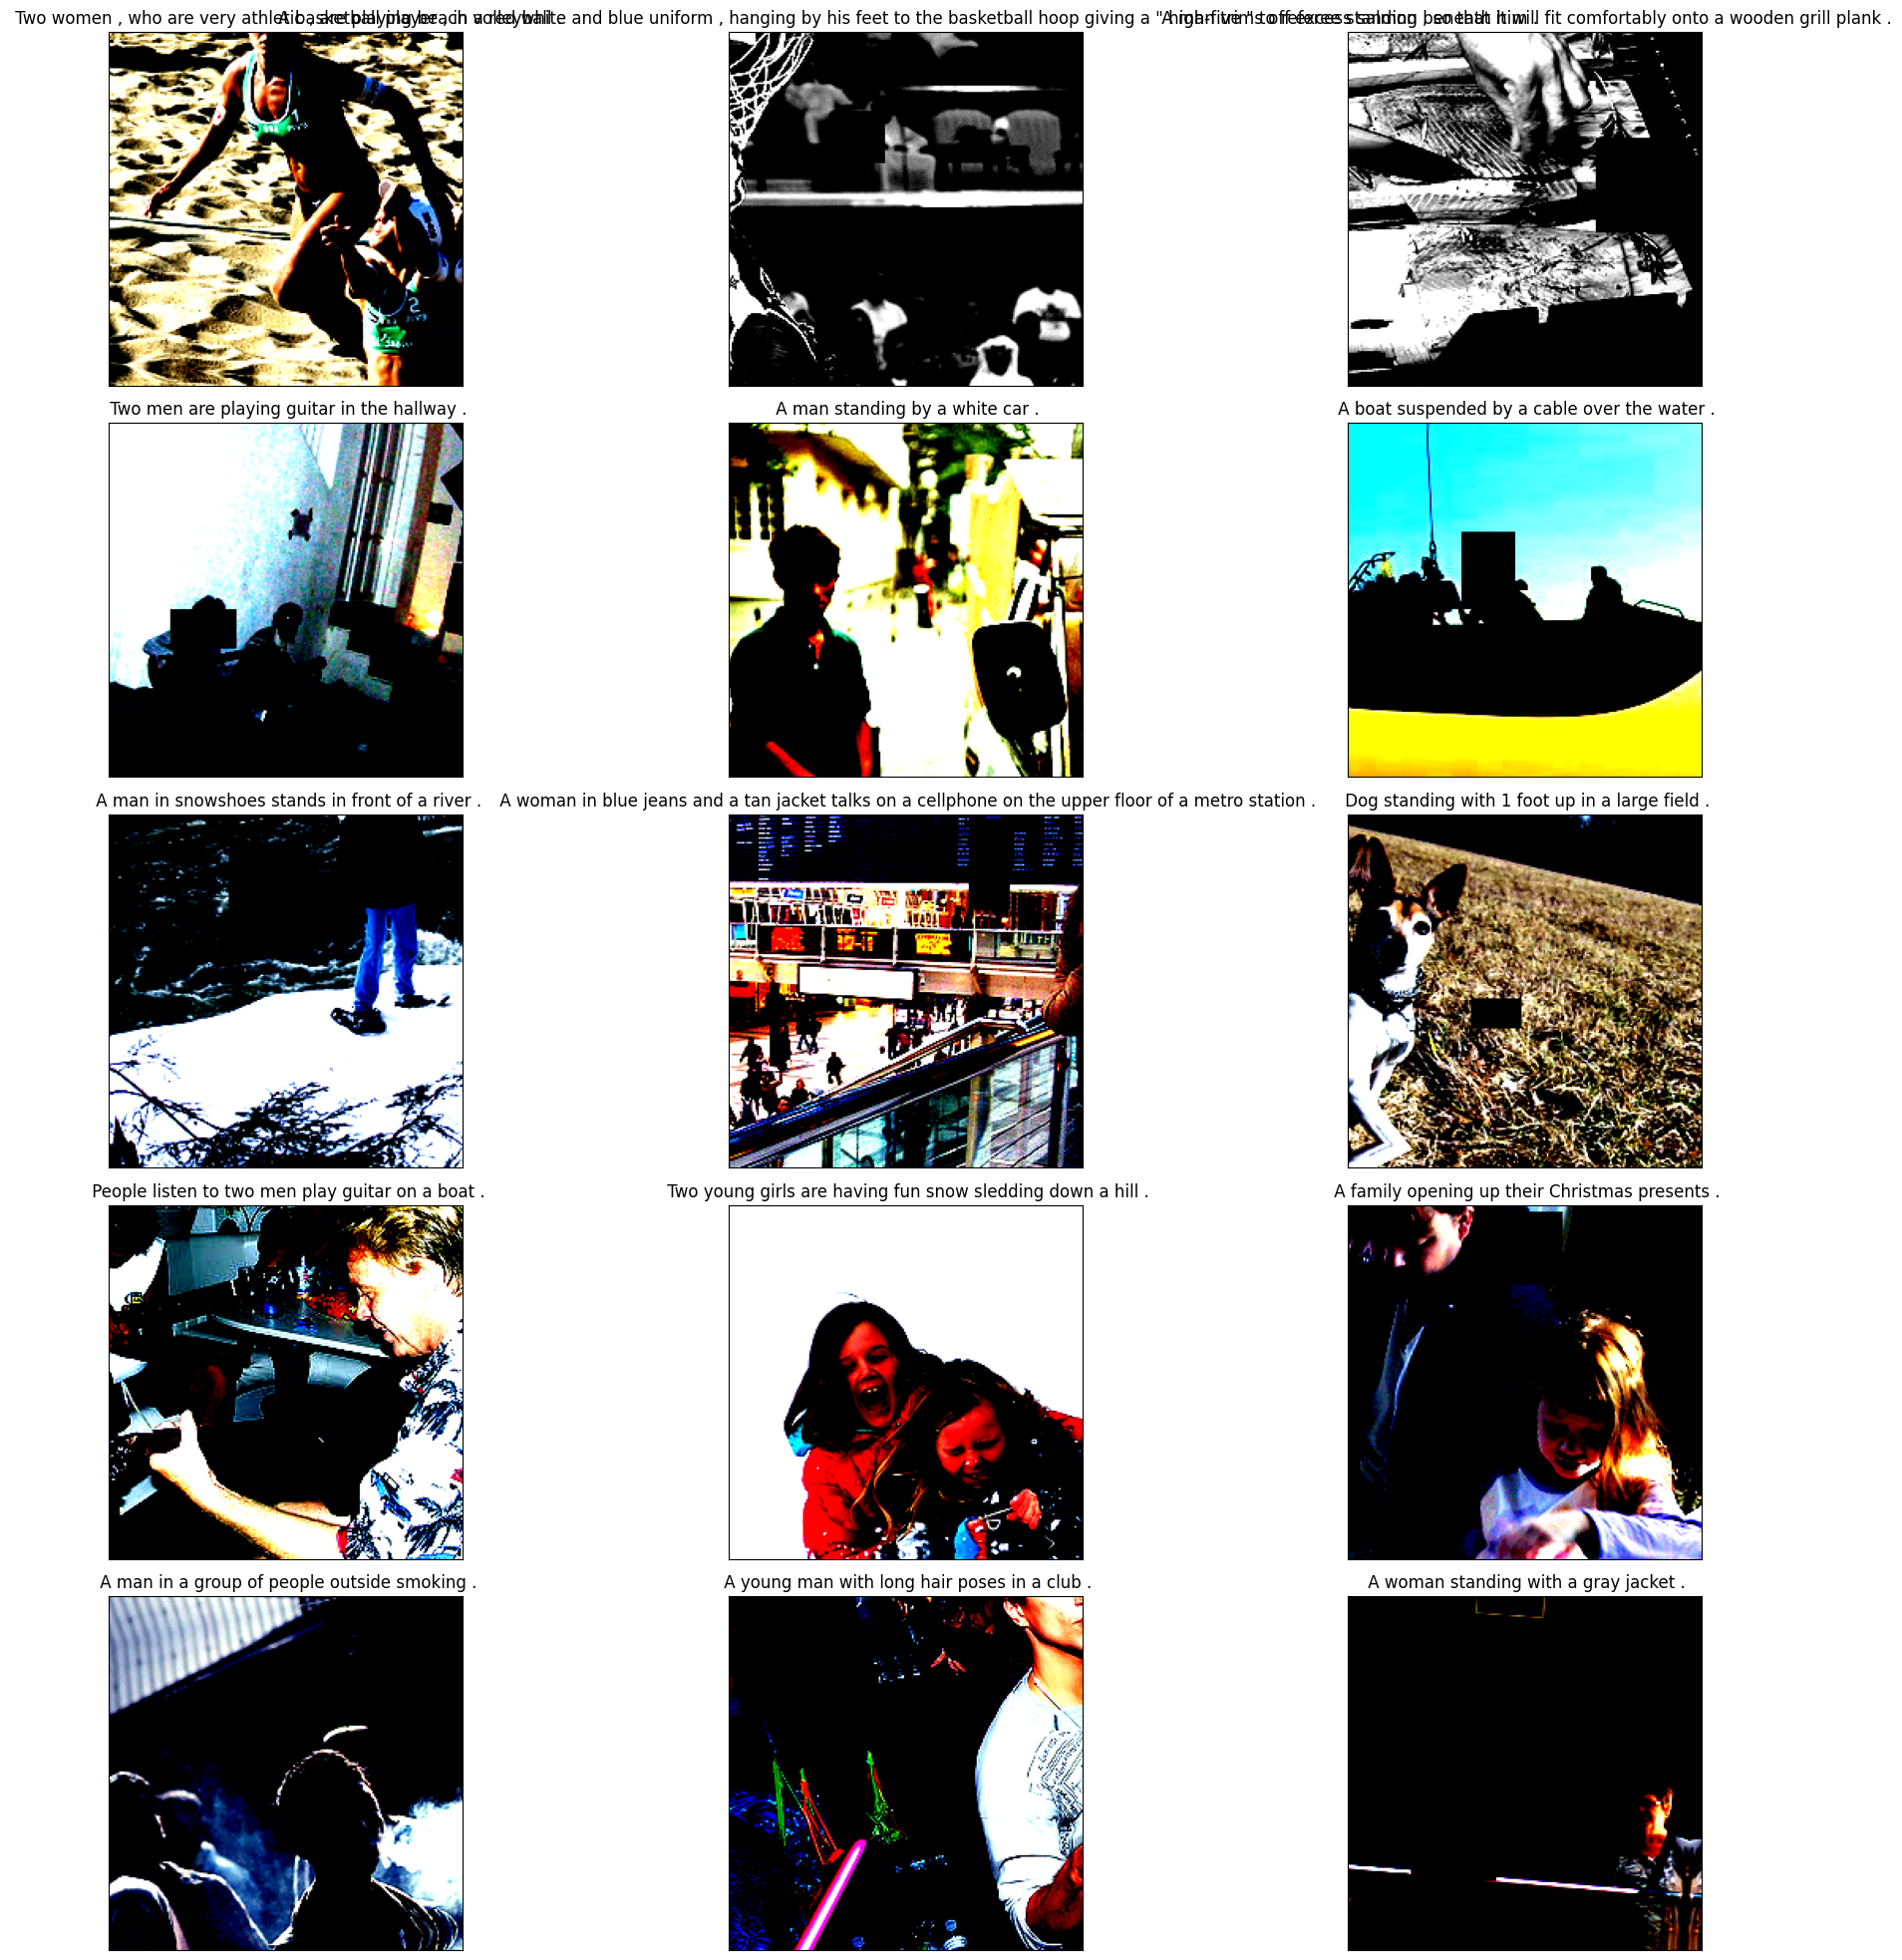

In [11]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(20, 20))
batch_data = next(iter(trainloader))


for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.tight_layout()

    # get an image - [3, 32, 32]
    # and denormalize
    image = batch_data["image"][i]

    # Clip the input data to the valid range [0, 1]
    image = image.clip(0, 1)
    
    # [3, 32, 32] to [32, 32, 3]
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    
    plt.title(batch_data["caption"][i])
    plt.xticks([])
    plt.yticks([])

In [12]:
class TimmImageEncoder(nn.Module):
    def __init__(self, model_name, pretrained, trainable):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [13]:
# from torchinfo import summary

# input_shape = (224, 224)
# model = TimmImageEncoder(model_name="resnet50", pretrained=True, trainable=True)

# summary(
#     model,
#     input_data=torch.rand((1, 3, input_shape[0], input_shape[1])),
# )

In [14]:
# print(print_number_of_trainable_model_parameters(model))

In [15]:
class DistilBertTextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=True):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, 
                            attention_mask=attention_mask)
        
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [16]:
# class GPT2TextEncoder(nn.Module):
#     def __init__(self, pad_token_id):
#         super(GPT2TextEncoder, self).__init__()
#         self.model = GPT2Model.from_pretrained("gpt2")

#         lora_config = LoraConfig(
#             inference_mode=False,
#             r=8,
#             lora_alpha=16,
#             lora_dropout=0.05,
#             bias="none",
#         )

#         self.model = get_peft_model(self.model, lora_config)
#         self.pad_token_id = pad_token_id
        
#     def forward(self, input_ids, attention_mask):
#         # logits shape: [batch=16, seqlen=1024, dim=768]
#         logits, _ = self.model(input_ids, 
#                                attention_mask=attention_mask,
#                                return_dict=False)

#         sequence_lengths = (torch.eq(input_ids, self.pad_token_id).long().argmax(-1) - 1).to(
#                     logits.device
#                 )

#         batch_size = input_ids.shape[0]
        
#         # pooled logits shape: [batch=16, dim=768]
#         pooled_logits = logits[torch.arange(batch_size, device=logits.device), sequence_lengths]
#         return pooled_logits

In [17]:
# model = GPT2TextEncoder(pad_token_id=tokenizer.pad_token_id)
# input_data = (torch.randint(low=0, high=100, size=(2, 10)), torch.ones((2, 10)))

# print(summary(model, input_data=input_data))
# print(f"Output shape: {model(input_data[0], input_data[1]).shape}")

In [18]:
# print(print_number_of_trainable_model_parameters(model))

In [19]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim,
        dropout
    ):
        super(ProjectionHead, self).__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.skip = nn.Sequential(
                            nn.GELU(),
                            nn.Linear(projection_dim, projection_dim),
                            nn.Dropout(dropout)
                            )
        self.layer_norm = nn.LayerNorm(projection_dim)

    def residue(self, x, layer):
        return x + layer(x)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.residue(projected, self.skip)
        x = self.layer_norm(x)
        return x

In [20]:
# model = ProjectionHead(embedding_dim=128, projection_dim=256, dropout=0.1)

# summary(
#     model,
#     input_data=torch.rand((1, 128)),
# )

In [21]:
# print(print_number_of_trainable_model_parameters(model))

In [22]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        image_embedding,
        text_embedding,
        dropout
    ):
        super(CLIPModel, self).__init__()
        self.image_encoder = TimmImageEncoder(model_name="resnet50", pretrained=True, trainable=True)
        # self.text_encoder = GPT2TextEncoder(pad_token_id=tokenizer.pad_token_id)
        self.text_encoder = DistilBertTextEncoder()
        
        self.image_projection = ProjectionHead(embedding_dim=image_embedding, projection_dim=256, dropout=dropout)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding, projection_dim=256, dropout=dropout)

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], 
            attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        return image_embeddings, text_embeddings

In [23]:
model = CLIPModel(image_embedding=2048, text_embedding=768, dropout=0.2)

image_embeddings, text_embeddings = model(next(iter(trainloader)))
image_embeddings.shape, text_embeddings.shape

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(torch.Size([64, 256]), torch.Size([64, 256]))

In [24]:
device = torch.device("mps")
model.to(device)

CLIPModel(
  (image_encoder): TimmImageEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), strid

In [26]:
from loss import CEPWLoss
criterion = CEPWLoss(device=device, temperature=1)

In [27]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau


params = [
    {"params": model.image_encoder.parameters(), "lr": 1e-4},
    {"params": model.text_encoder.parameters(), "lr": 1e-5},
    {"params": itertools.chain(
        model.image_projection.parameters(), model.text_projection.parameters()
    ), "lr": 1e-3, "weight_decay": 1e-3}
]

optimizer = AdamW(params, weight_decay=0.)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=1, factor=0.8)

In [28]:
def train(epoch, model, dataloader, device, optimizer, criterion):
    model.train()

    total_loss = 0
    point_count = 0

    ce_loss = 0
    ce_point_count = 0

    bce_loss = 0
    bce_point_count = 0
    
    pbar = tqdm(dataloader)
    to_device = lambda batch, key: batch[key].to(device)
    
    for mini_batch_id, batch in enumerate(pbar):
        batch["input_ids"] = to_device(batch, "input_ids")
        batch["attention_mask"] = to_device(batch, "attention_mask")
        batch["image"] = to_device(batch, "image")

        image_emb, text_emb = model(batch)

        losses = criterion(image_emb, text_emb)     
        loss = losses["total_loss"]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        batch_size = image_emb.shape[0]
        step = mini_batch_id + 1

        # CE Loss
        ce_count = 2 * batch_size
        ce_loss += losses["cross_entropy_loss"].detach().item() * ce_count
        ce_point_count += ce_count

        # BCE Loss
        bce_count = 2 * batch_size * (batch_size - 1)
        bce_loss += losses["bce_loss"].detach().item() * bce_count
        bce_point_count += bce_count

        # Total Loss
        total_loss += loss.detach().item() * (ce_count + bce_count)
        point_count += ce_count + bce_count
        
        pbar.set_description(f"Train Loss: {round(total_loss / point_count, 4)}, CE Loss: {round(ce_loss / ce_point_count, 4)}, BCE Loss: {round(bce_loss / bce_point_count, 4)}")

    return total_loss / point_count

In [29]:
def test(epoch, model, dataloader, device, criterion):
    model.eval()

    total_loss = 0
    point_count = 0

    ce_loss = 0
    ce_point_count = 0

    bce_loss = 0
    bce_point_count = 0
    
    pbar = tqdm(dataloader)
    to_device = lambda batch, key: batch[key].to(device)

    with torch.no_grad():
        for mini_batch_id, batch in enumerate(pbar):
            batch["input_ids"] = to_device(batch, "input_ids")
            batch["attention_mask"] = to_device(batch, "attention_mask")
            batch["image"] = to_device(batch, "image")
    
            image_emb, text_emb = model(batch)
            losses = criterion(image_emb, text_emb)
            
            step = mini_batch_id + 1
            batch_size = image_emb.shape[0]
    
            # CE Loss
            ce_count = 2 * batch_size
            ce_loss += losses["cross_entropy_loss"].detach().item() * ce_count
            ce_point_count += ce_count
    
            # BCE Loss
            bce_count = 2 * batch_size * (batch_size - 1)
            bce_loss += losses["bce_loss"].detach().item() * bce_count
            bce_point_count += bce_count
    
            # Total Loss
            total_loss += losses["total_loss"].detach().item() * (ce_count + bce_count)
            point_count += ce_count + bce_count

            pbar.set_description(f"Test Loss: {round(total_loss / point_count, 4)}, CE Loss: {round(ce_loss / ce_point_count, 4)}, BCE Loss: {round(bce_loss / bce_point_count, 4)}")

    return total_loss / point_count

In [30]:
EPOCHS = 2

for epoch in range(EPOCHS):
    train_loss = train(epoch, model, trainloader, device, optimizer, criterion)
    test_loss = test(epoch, model, testloader, device, criterion)
    
    scheduler.step(test_loss)

Train Loss: 1.267065, CE Loss: 2.303448, BCE Loss: 0.230537: 100%|█| 1987/1987 [
Test Loss: 1.2548, CE Loss: 2.3762, BCE Loss: 0.1334: 100%|█| 497/497 [14:45<00:
Train Loss: 0.69221, CE Loss: 1.314466, BCE Loss: 0.069886: 100%|█| 1987/1987 [5
Test Loss: 1.2319, CE Loss: 2.341, BCE Loss: 0.1226: 100%|█| 497/497 [13:54<00:0


In [41]:
EPOCHS = 2

for epoch in range(EPOCHS):
    train_loss = train(epoch, model, trainloader, device, optimizer, criterion)
    test_loss = test(epoch, model, testloader, device, criterion)
    
    scheduler.step(test_loss)

Train Loss: 0.560284, CE Loss: 1.070444, BCE Loss: 0.050072: 100%|█| 1987/1987 [
Test Loss: 1.2024, CE Loss: 2.2932, BCE Loss: 0.1115: 100%|█| 497/497 [15:59<00:
Train Loss: 0.481402, CE Loss: 0.922732, BCE Loss: 0.040023: 100%|█| 1987/1987 [
Test Loss: 1.2168, CE Loss: 2.3228, BCE Loss: 0.1109: 100%|█| 497/497 [14:28<00:


# Save Model

In [136]:
folder_path = "./checkpoint/v1/"

# save entire model
torch.save(model.state_dict(), os.path.join(folder_path, "model.pt"))

In [137]:
# save image encoder
torch.save(model.image_encoder.state_dict(), os.path.join(folder_path, "image_encoder.pt"))

# save text encoder
torch.save(model.text_encoder.state_dict(), os.path.join(folder_path, "text_encoder.pt"))

# image projection
torch.save(model.image_projection.state_dict(), os.path.join(folder_path, "image_projection.pt"))

# text projection
torch.save(model.text_projection.state_dict(), os.path.join(folder_path, "text_projection.pt"))

In [32]:
"""
This module provides utility functions for working with the 'peft' library and transformers models for sequence-to-sequence tasks. 
It includes functions for loading, saving, and merging models and tokenizers. 
The module also defines a class 'PeftModelUtils' with static methods for these operations.

Functions:
1. 'load_base_model':
   - Loads a base transformer model for sequence-to-sequence tasks from a specified model path.
   - Returns the loaded model and tokenizer.

2. 'load_from_peft_adapter':
   - Loads a model from a 'peft' adapter, optionally making it trainable.
   - Merges the adapter with the base model if specified.
   - Returns the loaded model and tokenizer.

3. 'save_peft_adapter':
   - Saves a 'peft' adapter model to a specified model path.

4. 'merge_peft_and_save':
   - Merges a 'peft' adapter with the base model, saving the merged model to a specified model path.

5. 'save_tokenizer':
   - Saves a tokenizer to a specified model path.

Class 'PeftModelUtils':
- This class encapsulates the utility functions for loading, saving, and merging 'peft' adapter models.
- It does not require instantiation and is intended to be used statically.

Parameters:
- 'model_path' (str): The path to the base transformer model or 'peft' adapter model.
- 'base_model_path' (str): The path to the base transformer model.
- 'peft_model_path' (str): The path to the 'peft' adapter model.
- 'train' (bool): If True, allows training of the 'peft' adapter model.
- 'merge_adapter' (bool): If True, merges the 'peft' adapter with the base model.

Example Usage:
1. Loading a base model:
   model, tokenizer = PeftModelUtils.load_base_model(model_path="google/flan-t5-base")

2. Loading a model from a 'peft' adapter:
   model, tokenizer = PeftModelUtils.load_from_peft_adapter(
       base_model_path="google/flan-t5-base",
       peft_model_path="./path/to/peft/adapter/model",
       train=True,
       merge_adapter=True
   )

3. Saving a 'peft' adapter model:
   PeftModelUtils.save_peft_adapter(model, model_path="./path/to/save/peft/adapter")

4. Merging a 'peft' adapter with the base model and saving:
   PeftModelUtils.merge_peft_and_save(model, model_path="./path/to/save/merged/model")

5. Saving a tokenizer:
   PeftModelUtils.save_tokenizer(tokenizer, model_path="./path/to/save/tokenizer")

Note:
- The 'peft' library and the 'transformers' library are required dependencies for this module to function properly.
"""


import os, json
from peft import PeftModel
import torch


class PeftModelUtils:
    @staticmethod
    def load_base_model(model_class, tokenizer_class, model_path):
        """
        Loads a base transformer model for sequence-to-sequence tasks from the specified model path.

        Parameters:
            model_path (str): The path or identifier of the base transformer model to load.

        Returns:
            model (PreTrainedModel): The loaded transformer model.
            tokenizer (PreTrainedTokenizer): The associated tokenizer for the model.
        """
        model = model_class.from_pretrained(
            model_path, torch_dtype=torch.bfloat16, device_map="auto"
        )
        tokenizer = tokenizer_class.from_pretrained(model_path)
        return model, tokenizer

    @staticmethod
    def load_from_peft_adapter(
        adapter_path: str,
        base_model_class,
        tokenizer_class,
        base_model_path: str = None,
        train: bool = False,
        merge_adapter: bool = False,
    ):
        """
        Loads a model from a 'peft' adapter, optionally making it trainable and merging it with the base model.

        Parameters:
            base_model_path (str): The path or identifier of the base transformer model.
            peft_model_path (str): The path to the 'peft' adapter model.
            train (bool): If True, allows training of the 'peft' adapter model (default is False).
            merge_adapter (bool): If True, merges the 'peft' adapter with the base model (default is False).

        Returns:
            model (PeftModel): The loaded 'peft' model, optionally merged with the base model.
            tokenizer (PreTrainedTokenizer): The associated tokenizer for the model.
        """
        if base_model_path is None:
            base_model_path = PeftModelUtils.get_base_model_path_of_peft_adapter(
                adapter_path=adapter_path
            )

        model, tokenizer = PeftModelUtils.load_base_model(base_model_class, tokenizer_class, base_model_path)
        model = PeftModel.from_pretrained(
            model,
            adapter_path,
            torch_dtype=torch.bfloat16,
            is_trainable=train,
            device_map="auto",
        )

        # merge the adapter to the main model
        if merge_adapter:
            model = model.merge_and_unload()

            if train:
                for param in model.parameters():
                    param.requires_grad = True

        return model, tokenizer

    @staticmethod
    def save_peft_adapter(model, model_path):
        model.save_pretrained(model_path)

    @staticmethod
    def merge_peft_and_save(model, model_path):
        model = model.merge_and_unload()
        model.save_pretrained(model_path)

    @staticmethod
    def save_tokenizer(tokenizer, model_path):
        tokenizer.save_pretrained(model_path)

    @staticmethod
    def get_base_model_path_of_peft_adapter(adapter_path):
        config_path = os.path.join(adapter_path, "adapter_config.json")

        with open(config_path, "r") as file:
            config = json.load(file)

        return config["base_model_name_or_path"]

In [34]:
# save gpt2 adapter
PeftModelUtils.save_peft_adapter(model.text_encoder.model, folder_path)

In [35]:
PeftModelUtils.get_base_model_path_of_peft_adapter(folder_path)

'gpt2'

# Inference

In [22]:
folder_path = "./checkpoint/v1/"
model.load_state_dict(torch.load(os.path.join(folder_path, "model.pt"), map_location=device))

<All keys matched successfully>

In [31]:
from typing import List
import matplotlib.pyplot as plt


def get_text_embedding(model, tokenizer, device, text: List):
    model.eval()
    
    batch = tokenizer(text, padding=True, truncation=True, max_length=200)
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in batch.items()
    }

    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], 
            attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    return text_embeddings

In [32]:
def get_image_embedding(model, images: torch.Tensor):
    """
    images shape: [batch, 3, 224, 224]
    """
    model.eval()

    with torch.no_grad():
        image_features = model.image_encoder(images)
        image_embeddings = model.image_projection(image_features)
        
    return image_embeddings

In [33]:
def find_matches(model, tokenizer, device, image_embeddings, query, image_filenames, n=4):
    text_embeddings = get_text_embedding(model, tokenizer, device, text=[query])
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    # plot images
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(match)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

In [34]:
def collate_image_embeddings(model, dataloader, device):    
    pbar = tqdm(dataloader)
    embeddings = []
    filenames = []
    
    with torch.no_grad():
        for mini_batch_id, batch in enumerate(pbar):
            batch["image"] = batch["image"].to(device)

            embeddings.append(get_image_embedding(model, batch["image"]))
            filenames.extend(batch["image_path"])

    return torch.cat(embeddings), filenames

In [42]:
image_embeddings, image_filenames = collate_image_embeddings(model, testloader, device)

100%|█████████████████████████████████████████| 497/497 [06:02<00:00,  1.37it/s]


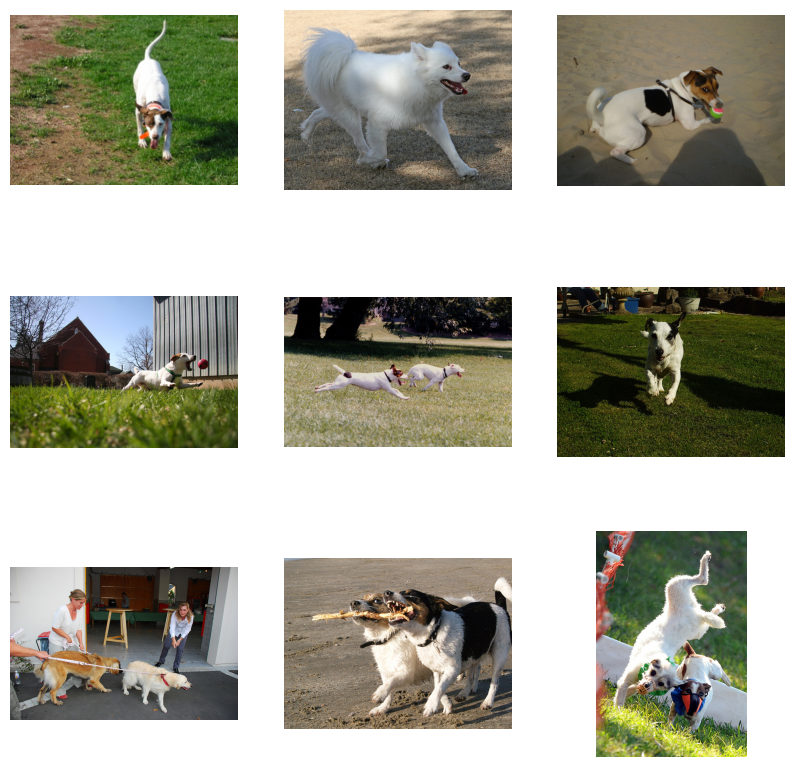

In [58]:
find_matches(model, 
             tokenizer, 
             device, 
             image_embeddings, 
             "white dogs", 
             image_filenames, 
             n=10)

In [ ]:
# crowd in street / crowd in stadium
# black dog / brown dog / dogs playing
# smoke / smoking
# football / beasts playing football
# men sports / women sports